# Mounting Drive and Installing Modules

In [0]:
## Import general system modules
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader
from itertools import product
from itertools import chain
import time as time
import random 
import pickle
import gzip
import sys
import os

In [0]:
drive.mount('/content/gdrive')
models_dir = '/content/gdrive/My Drive/Colab/otto/base_models'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE 
%matplotlib inline

#Pytorch Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


     |████████████████████████████████| 64.4MB 48kB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Importing Data and creating transformed datasets

In [0]:
#Loading raw data

train = pd.read_csv("/content/gdrive/My Drive/Colab/otto/train.csv", index_col = 0)
sample = pd.read_csv("/content/gdrive/My Drive/Colab/otto/sampleSubmission.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab/otto/test.csv", index_col = 0)

In [0]:
#Specify scalers

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

In [0]:
# Scaling 

train_mean_scaled = train.drop(['target'], axis=1)
train_zero_scaled = train.drop(['target'], axis=1)

train_mean_scaled = pd.DataFrame(standard_scaler.fit_transform(train_mean_scaled))
test_mean_scaled = pd.DataFrame(standard_scaler.fit_transform(test))

train_zero_scaled = pd.DataFrame(min_max_scaler.fit_transform(train_zero_scaled))
test_zero_scaled = pd.DataFrame(min_max_scaler.fit_transform(test))

train_log = train.drop(['target'], axis=1)
train_log = np.log(train_log+1)
test_log = np.log(test+1)

In [0]:
# Preparing dataframes for stacking 

y_train = train['target'].ravel()
train = train.drop(['target'], axis=1)
x_train = train.values 
x_test = test.values 

x_train_mean_scaled = train_mean_scaled.values 
x_test_mean_scaled = test_mean_scaled.values 

x_train_zero_scaled = train_zero_scaled.values 
x_test_zero_scaled = test_zero_scaled.values 

train_log = train_log.values
test_log = test_log.values

### Hypertuning XGboost with TSNE features

In [0]:
params_xgboost = {
 "learning_rate"    : [0.09, 0.095, 0.1, 0.15, 0.2, 0.25, 0.3],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 'n_estimators'     : [100, 150, 200, 250, 300],
 'tree_method' : ['gpu_hist'] 
}

In [0]:
clf=XGBClassifier()

random_search = RandomizedSearchCV(estimator = clf, 
                      param_distributions = params_xgboost, 
                      n_iter = 20, 
                      cv = 5, 
                      verbose=20, 
                      random_state=2,
                      scoring = 'neg_log_loss', 
                      n_jobs = -1)

random_search.fit(x_train_mean_UMAP_TSNE, y_train)

print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

Best: -0.457632 using {'tree_method': 'gpu_hist', 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.3}


In [0]:
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-0.614317 (0.006198) with: {'tree_method': 'gpu_hist', 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.3}
-0.470777 (0.006616) with: {'tree_method': 'gpu_hist', 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.4}
-0.464901 (0.008008) with: {'tree_method': 'gpu_hist', 'n_estimators': 250, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.5}
-0.493778 (0.007817) with: {'tree_method': 'gpu_hist', 'n_estimators': 250, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}
-0.522134 (0.010154) with: {'tree_method': 'gpu_hist', 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.3}
-0.461207 (0.007680) with: {'tree_method': 'gpu_hist', 'n_estimators': 150, 'min_child_weight': 7, 'max_depth': 12, '

# Visualisations


Some correlated pairs, but generally littl correlation in the training set

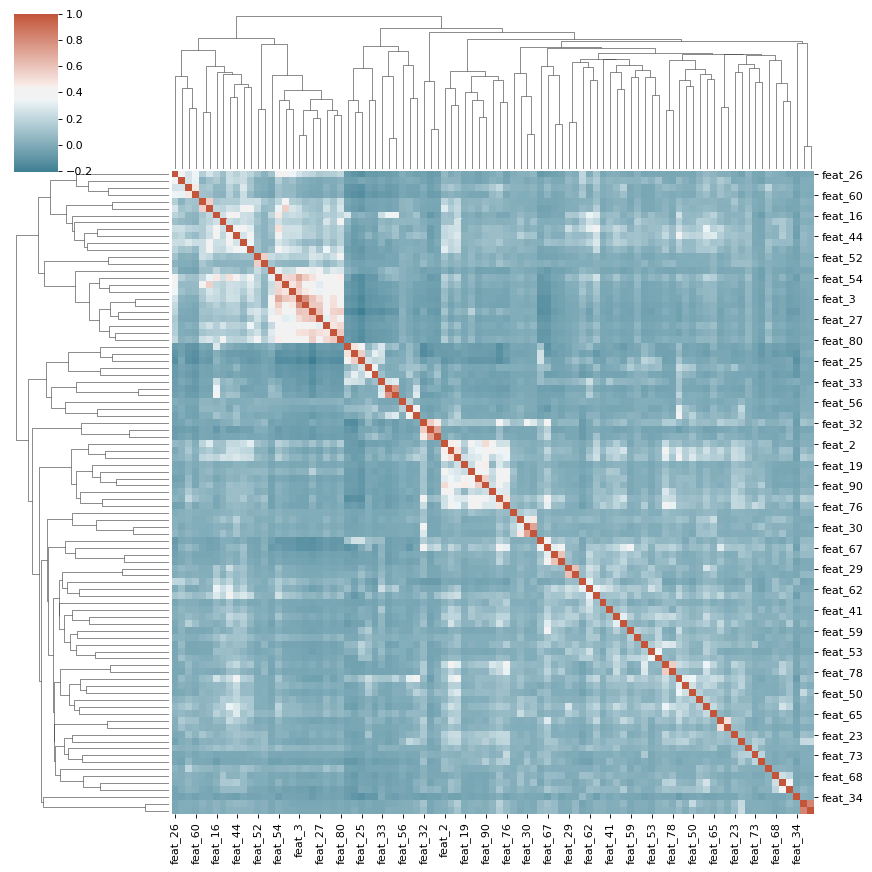

In [0]:
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(train.corr(), figsize= (11,11), cmap = cmap).ax_row_dendrogram.set_visible(True)

Checking distrubution of dataset 

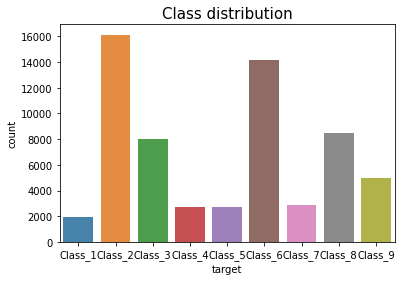

In [0]:
ax = sns.countplot(x='target', data=pd.read_csv("/content/gdrive/My Drive/Colab/otto/train.csv", index_col = 0), alpha=0.9, palette="tab10").set_title('Class distribution', size=15)

Clearly there is multiclass imbalance 

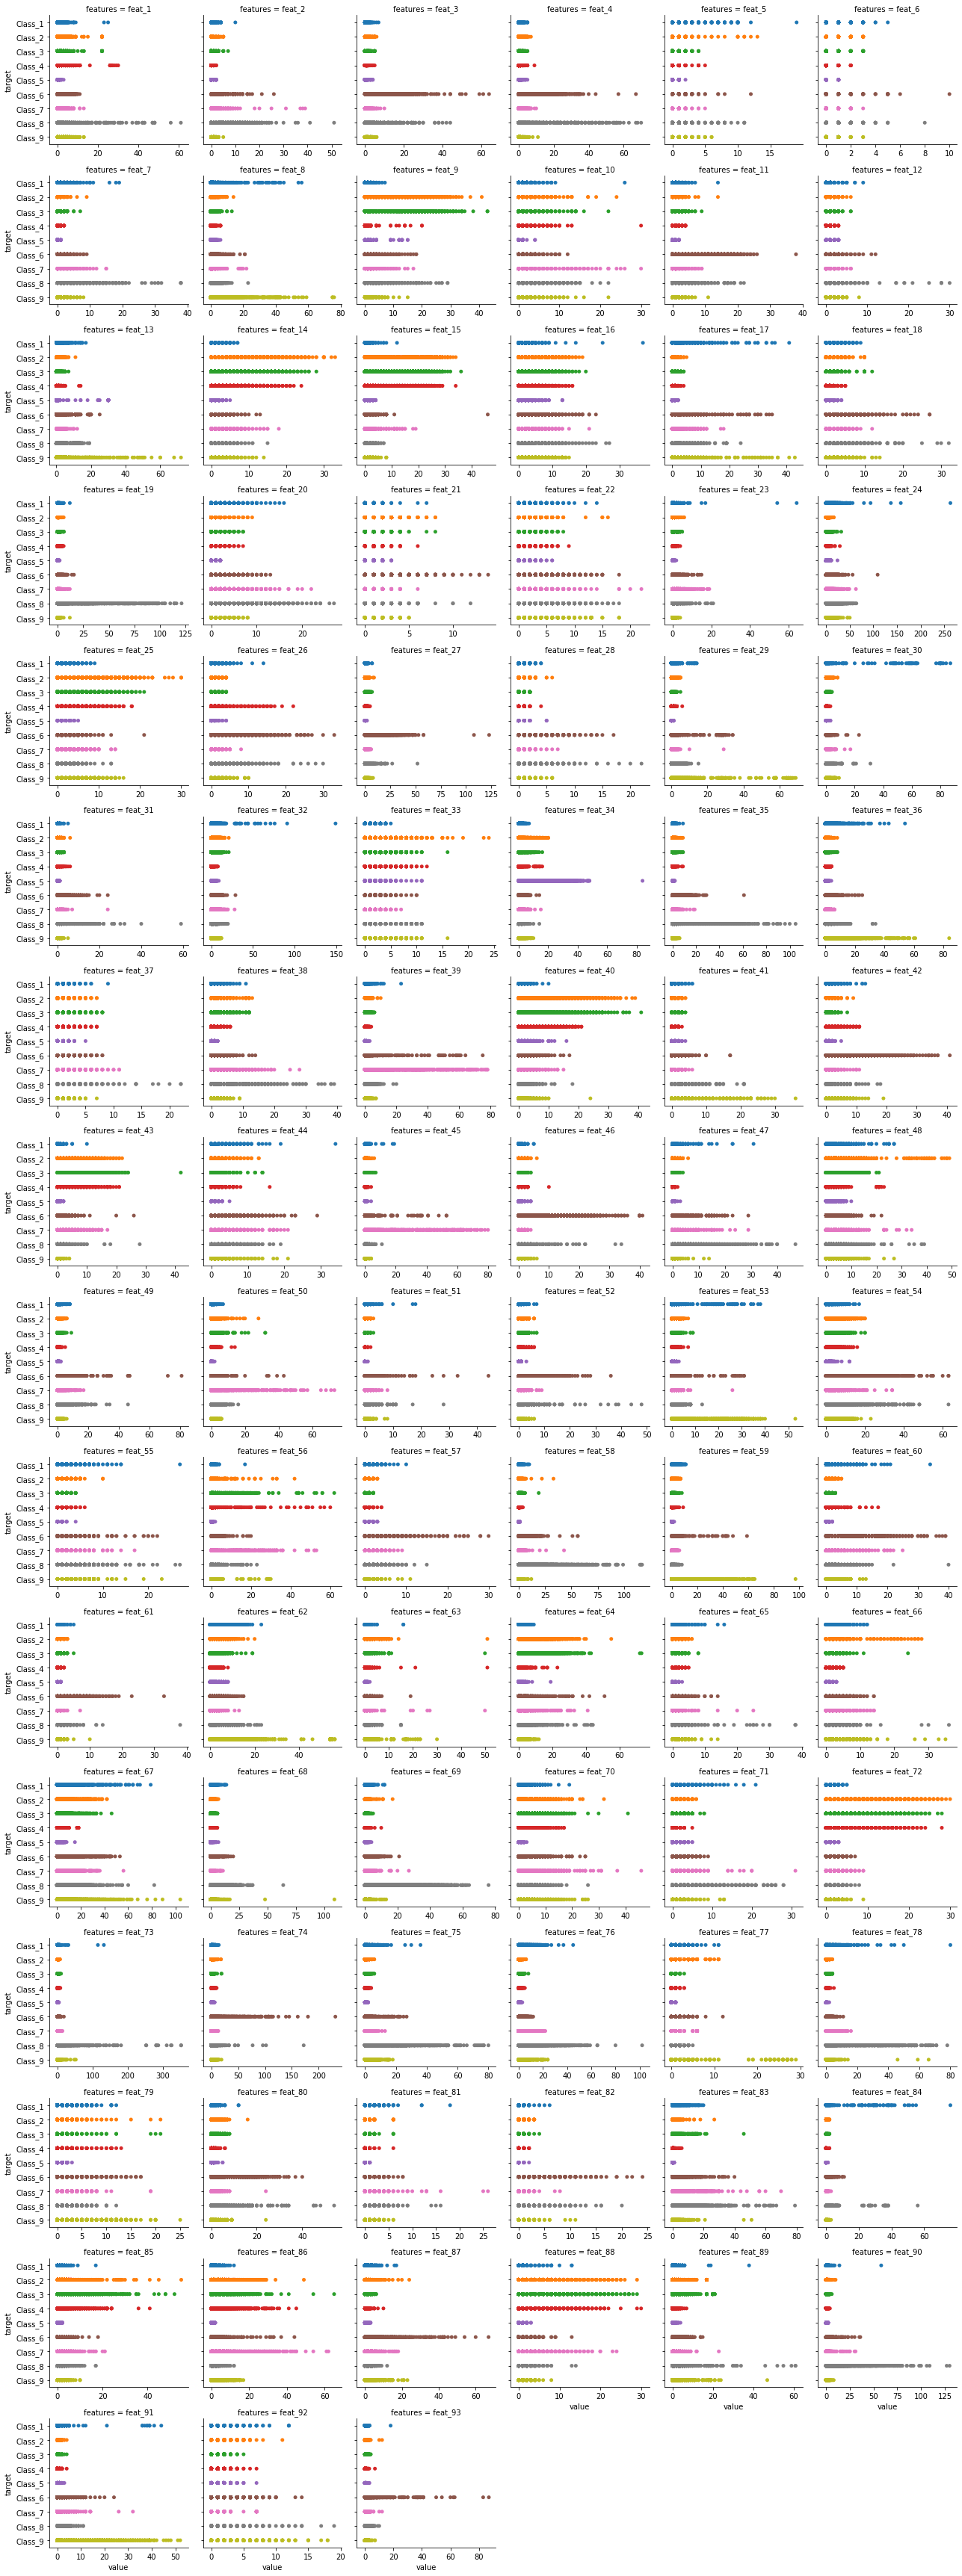

In [0]:
train_wide = pd.read_csv("train.csv", index_col = 0).melt(id_vars=['target'], var_name='features')
sns.catplot(data=train_wide, x='value', y='target', col='features', 
            col_wrap=6, 
            height=3, 
            aspect=1, 
            sharex=False,
            jitter=False)

# Stacking

In [0]:
# Sklearn Helper Class

SEED = 1 
NFOLDS = 2 
shuffle = True # wana shuffle data?
n_classes = len(np.unique(y_train))

kf = StratifiedKFold(n_splits = NFOLDS, shuffle = shuffle, random_state = SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)  

In [0]:
#Stacking function

def stack(mName, clf, x_train, y_train, x_test):
    stack_train = np.zeros((x_train.shape[0], n_classes))
    stack_test = np.zeros((x_test.shape[0], n_classes))
    stack_test_temp = np.zeros((NFOLDS, x_test.shape[0], n_classes))

    print('Stacking classifier:', mName)    

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te = y_train[test_index]

        clf.train(x_tr, y_tr)

        stack_train[test_index] = clf.predict(x_te)
        stack_test_temp[i, :] = clf.predict(x_test)

        print('LogLoss {score}'.format(score=log_loss(y_te, clf.predict(x_te))))

    stack_test[:] = np.mean(stack_test_temp, axis=0)

    #Save training predictions to Gdrive
    fname = models_dir + '/train-' + mName
    _ = joblib.dump(stack_train, fname, compress=9)

    Save testing predictions to Gdrive
    fname = models_dir + '/test-' + mName
    _ = joblib.dump(stack_test, fname, compress=9)

    return stack_train, stack_test

# Model Params

In [0]:
#Model params - params found using random search

lr_params = {
  'multi_class': 'multinomial',
  'solver' : 'newton-cg'
}

nb_params = {}

rf_params = {'bootstrap': False,
'max_depth': 40,
'max_features': 'auto',
'min_samples_leaf': 2,
'min_samples_split': 4,
'random_state': 1,
'n_estimators': 200,
'n_jobs': -1}

rf_cal_params = {'bootstrap': False,
'max_depth': 40,
'max_features': 'auto',
'min_samples_leaf': 2,
'min_samples_split': 4,
'n_estimators': 200,
'n_jobs': -1}

et_params = {'bootstrap': False,
'max_depth': 150,
'max_features': 'auto',
'min_samples_leaf': 1,
'min_samples_split': 5,
'n_estimators': 250,
'n_jobs': -1}

knn_4_params = {'n_neighbors': 4,
          'n_jobs': -1
}

knn_8_params = {'n_neighbors': 8,
          'n_jobs': -1
}

knn_16_params = {'n_neighbors': 16,
          'n_jobs': -1
}

knn_32_params = {'n_neighbors': 32,
          'n_jobs': -1
}

knn_64_params = {'n_neighbors': 64,
          'n_jobs': -1
}

knn_128_params = {'n_neighbors': 128,
          'n_jobs': -1
}

knn_256_params = {'n_neighbors': 256,
          'n_jobs': -1
}

xgboost_params = {'colsample_bytree': 0.4,
'gamma': 0.3,
'learning_rate': 0.25,
'max_depth': 15,
'min_child_weight': 5,
'n_estimators': 100,
'objective': 'multi:softprob',
'tree_method': 'gpu_hist',
'n_jobs': -1}

xgboost_log_params = {'colsample_bytree': 0.3,
'gamma': 0.1,
'learning_rate': 0.1,
'max_depth': 12,
'min_child_weight': 1,
'n_estimators': 200,
'objective': 'multi:softprob',
'tree_method': 'gpu_hist',
'n_jobs': -1}

mlp_params = {'solver': 'adam',
            'alpha': 1e-5,
            'hidden_layer_sizes': 50,
            'random_state': 1,
            'learning_rate_init': 0.001,
            'max_iter': 400,
            'verbose': False,
            'tol': 0.00001}

lgbm_dart_params = {'objective': 'multiclass',
'n_estimators': 500,
'learning_rate': 0.07,
'boosting_type': 'dart',
'metric': 'multi_logloss',
'n_jobs': -1}

lgbm_gbdt_params =  {'objective': 'multiclass',
'n_estimators': 550,
'learning_rate': 0.065,
'boosting_type': 'gbdt',
'metric': 'multi_logloss',
'n_jobs': -1}

catboost_params = {'n_estimators': 450, 
                      'learning_rate': 0.3}

xgboost_umap_tsne_mean_params = {'colsample_bytree': 0.3,
'gamma': 0.0,
'learning_rate': 0.1,
'max_depth': 10,
'min_child_weight': 5,
'n_estimators': 250,
'objective': 'multi:softprob',
'n_jobs': -1,
'tree_method': 'gpu_hist'}

# Initialising models

In [0]:
#Initialise Models 

lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
nb = SklearnHelper(clf=MultinomialNB, seed=SEED, params=nb_params)
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
knn_4 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_4_params)
knn_8 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_8_params)
knn_16 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_16_params)
knn_32 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_32_params)
knn_64 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_64_params)
knn_128 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_128_params)
knn_256 = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_256_params)
xg = SklearnHelper(clf=XGBClassifier, seed=SEED, params=xgboost_params)
mlp = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params)
lgmb_dart = SklearnHelper(clf=LGBMClassifier, seed=SEED, params=lgbm_dart_params)
lgmb_gbdt = SklearnHelper(clf=LGBMClassifier, seed=SEED, params=lgbm_gbdt_params)
catboost = SklearnHelper(clf=CatBoostClassifier, seed=SEED, params=catboost_params)
xg_transform = SklearnHelper(clf=XGBClassifier, seed=SEED, params=xgboost_log_params)

# Call stacking function for specified base models

In [0]:
#lr_stack_train, lr_stack_test = stack('Softmax_0', lr,x_train, y_train, x_test)
#print('softmax done')
#mlp_stack_train, mlp_stack_test = stack('mlp_small_0', mlp, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('mlp done')
#xg_stack_train, xg_stack_test = stack('xgboost',xg, x_train, y_train, x_test)
#print('xg boost done')
#nb_stack_train, nb_stack_test = stack('Neive Bayes_0', nb, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('neive bayes done')
#rf_stack_train, rf_stack_test = stack('random_forest',rf, x_train, y_train, x_test)
#print('random forest done')
#et_stack_train, et_stack_test = stack('extra_trees', et, x_train, y_train, x_test)
#print('extra trees done')
#knn_4_stack_train, knn_4_stack_test = stack('knn_4_0', knn_4, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('knn 4 done')
#knn_8_stack_train, knn_8_stack_test = stack('knn_8_0',knn_8, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('knn 8 done')
#knn_16_stack_train, knn_16_stack_test = stack('knn_16_0',knn_16, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('knn 16 done')
#knn_32_stack_train, knn_32_stack_test = stack('knn_32_0',knn_32, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('knn 32 done')
#knn_64_stack_train, knn_64_stack_test = stack('knn_64_0',knn_64, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('kmm 64 done')
#knn_128_stack_train, knn_128_stack_test = stack('knn_128_0',knn_128, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('knn 128 done')
#knn_256_stack_train, knn_256_stack_test = stack('knn_256_0',knn_256, x_train_zero_scaled, y_train, x_test_zero_scaled)
#print('knn 256 done')
#lgmb_dart_stack_train, lgmb_dart_stack_test = stack('lgmb_dart',lgmb_dart, x_train, y_train, x_test)
#print('lgmb_dart done')
#lgmb_gbdt_stack_train, lgmb_gbdt_stack_test = stack('lgmb_gbdt',lgmb_gbdt, x_train, y_train, x_test)
#print('lgmb_gbdt done')
#catboost_stack_train, catboost_stack_test = stack('catboost',catboost, x_train, y_train, x_test)
#print('knn 256 done')
#XG_UMAPTSNE_mean_stack_train, XG_UMAPTSNE_mean_stack_test = stack('xgboost',xg, y_train, x_test_zero_UMAP_TSNE)
#print('xg_umap_tsne_zero')


NameError: ignored

# Compare results

In [0]:
# creating df for results to plot
## This dataframe should have been created in the stacking loop...
base_model_results = pd.DataFrame({
     'Pytorch MLP 01scaled': 0.4573,
     'Pytorch MLP logXplus1': 0.4660,
     'Pytorch MLP notscaled': 0.4421,
     'Pytorch MLP stdscaled': 0.4524,
     'Catboost': 0.5188,
     'Extra Trees': 0.6281,
     'KNN16': 1.2881,
     'KNN 32': 1.1223,
     'KNN 64': 0.9472,
     'KNN 128': 0.7376,
     'KNN 256': 0.6994,
     'LGMB Dart': 0.5194,
     'LGMB Gbdt': 0.4993,
     'MLP Sklearn': 0.5647,
     'Naive Bayes': 1.3079,
     'Random Forest': 0.5932,
     'Softmax': 0.6465,
     'XGBoost': 0.4929,
     'Logistic Regression': 0.6714,
     'Logistic Regression(LogX1)': 0.6763,
     'XGBoost UMAP features': 0.5148,
     'Meta Pytorch MLP': 0.40521,
     'Meta Calibrated Random Forest': 0.41531,
     'Meta XGBoost': 0.40031,
     'Meta model average': 0.39876
    }, index=[0])

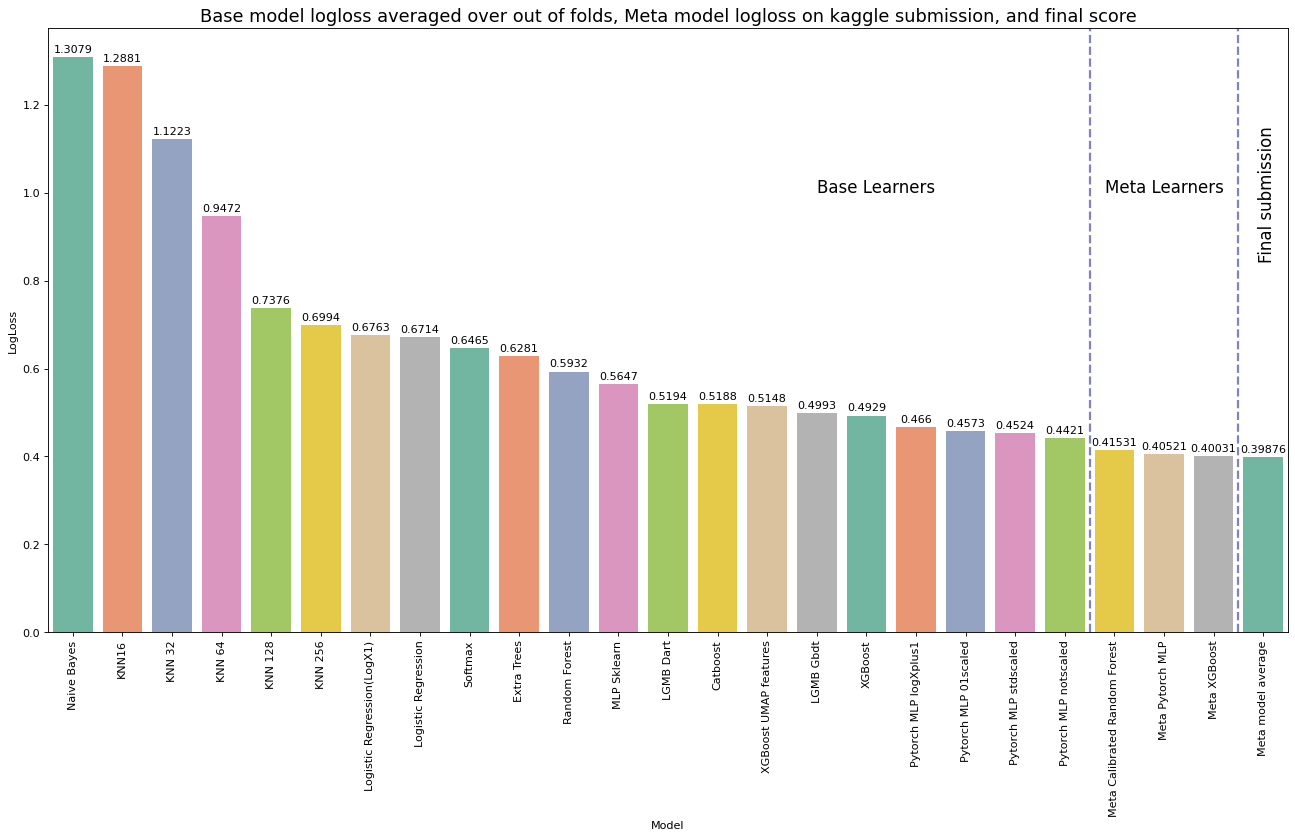

In [0]:
plot = pd.melt(base_model_results).sort_values(by='value', ascending=False)

plt.rcParams['figure.dpi'] = 80

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(ax=ax,x='variable', y= 'value', data=plot, palette = 'Set2')
ax.set(xlabel='Model', ylabel='LogLoss') 
plt.xticks(rotation=90)
plt.title('Base model logloss averaged over out of folds, Meta model logloss on kaggle submission, and final score', size=16)

ax.axvline(20.5, ls='--', linewidth=2, color='#000980', alpha = 0.5)
ax.axvline(23.5, ls='--', linewidth=2, color='#000980', alpha = 0.5)

ax.text(15, 1, "Base Learners", size=15)
ax.text(20.81, 1, "Meta Learners", size=15)
ax.text(23.9, 0.85, "Final submission", size=15, rotation=90)


for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2., height + 0.01 ,height ,ha="center")

Stacking classifier: xgboost_log+1
LogLoss 0.4972839631020909
LogLoss 0.492930490337424


KeyboardInterrupt: ignored

# Importing base predictions

In [0]:
#loading base learner train and test predictions 

BigMLP_01scaled_train = joblib.load(models_dir + '/train-bigNN-01scaled')
BigMLP_01scaled_test = joblib.load(models_dir + '/test-bigNN-01scaled')

BigMLP_logXplus1_train = joblib.load(models_dir + '/train-bigNN-log(x+1)')
BigMLP_logXplus1_test = joblib.load(models_dir + '/test-bigNN-log(x+1)')

BigMLP_notscaled_train = joblib.load(models_dir + '/train-bigNN-notscaled')
BigMLP_notscaled_test = joblib.load(models_dir + '/test-bigNN-notscaled')

BigMLP_stdscaled_train = joblib.load(models_dir + '/train-bigNN-standardscaled')
BigMLP_stdscaled_test = joblib.load(models_dir + '/test-bigNN-standardscaled')

catboost_train = joblib.load(models_dir + '/train-catboost')
catboost_test = joblib.load(models_dir + '/test-catboost')

extraTrees_train = joblib.load(models_dir + '/train-extra_trees')
extraTrees_test = joblib.load(models_dir + '/test-extra_trees')

KNN16_train = joblib.load(models_dir + '/train-knn_16_0')
KNN16_test = joblib.load(models_dir + '/test-knn_16_0')

KNN32_train = joblib.load(models_dir + '/train-knn_32_0')
KNN32_test = joblib.load(models_dir + '/test-knn_32_0')

KNN64_train = joblib.load(models_dir + '/train-knn_64_0')
KNN64_test = joblib.load(models_dir + '/test-knn_64_0')

KNN128_train = joblib.load(models_dir + '/train-knn_128_0')
KNN128_test = joblib.load(models_dir + '/test-knn_128_0')

KNN256_train = joblib.load(models_dir + '/train-knn_256_0')
KNN256_test = joblib.load(models_dir + '/test-knn_256_0')

LGMB_dart_train = joblib.load(models_dir + '/train-lgmb_dart')
LGMB_dart_test = joblib.load(models_dir + '/test-lgmb_dart')

LGMB_gbdt_train = joblib.load(models_dir + '/train-lgmb_gbdt')
LGMB_gbdt_test = joblib.load(models_dir + '/test-lgmb_gbdt')

smallMLP_scaled_train = joblib.load(models_dir + '/train-mlp_small_0')
smallMLP_scaled_test = joblib.load(models_dir + '/test-mlp_small_0')

NaiveBayes_train = joblib.load(models_dir + '/train-Neive Bayes')
NaiveBayes_test = joblib.load(models_dir + '/test-Neive Bayes')

NaiveBayes_scaled_train = joblib.load(models_dir + '/train-Neive Bayes_0')
NaiveBayes_scaled_test = joblib.load(models_dir + '/test-Neive Bayes_0')

randomForest_train = joblib.load(models_dir + '/train-random_forest')
randomForest_test = joblib.load(models_dir + '/test-random_forest')

softmax_train = joblib.load(models_dir + '/train-Softmax')
softmax_test = joblib.load(models_dir + '/test-Softmax')

xgboost_train = joblib.load(models_dir + '/train-xgboost')
xgboost_test = joblib.load(models_dir + '/test-xgboost')

UMAP9_train = joblib.load(models_dir + '/train-UMAP9')
UMAP9_test = joblib.load(models_dir + '/test-UMAP9')

TSNE3_train = joblib.load(models_dir + '/train-TSNE3')
TSNE3_test = joblib.load(models_dir + '/test-TSNE3')

log_reg_train = joblib.load(models_dir + '/train-LogReg')
log_reg_test = joblib.load(models_dir + '/test-LogReg')

log_reg_x1_train = joblib.load(models_dir + '/train-LogReg-log(X+1)')
log_reg_x1_test = joblib.load(models_dir + '/test-LogReg-log(X+1)')

xgboost_umaptsne_zero_train = joblib.load(models_dir + '/train-XG_UMAP_TSNE_zero')
xgboost_umaptsne_zero_test = joblib.load(models_dir + '/test-XG_UMAP_TSNE_zero')

# Visualising correlation in base model train and test predictions

In [0]:
#Create pd dataframes and plot cor plots for train and test predictions

base_model_df_train = pd.DataFrame({
     'BigMLP 01scaled': BigMLP_01scaled_train.ravel(),
     'BigMLP logXplus1': BigMLP_logXplus1_train.ravel(),
     'BigMLP notscaled': BigMLP_notscaled_train.ravel(),
     'BigMLP stdscaled': BigMLP_stdscaled_train.ravel(),
     'Catboost': catboost_train.ravel(),
     'Extra Trees': extraTrees_train.ravel(),
     'KNN16': KNN16_train.ravel(),
     'KNN 32': KNN32_train.ravel(),
     'KNN 64': KNN64_train.ravel(),
     'KNN 128': KNN128_train.ravel(),
     'KNN 256': KNN256_train.ravel(),
     'LGMB Dart': LGMB_dart_train.ravel(),
     'LGMB Gbdt': LGMB_gbdt_train.ravel(),
     'MLP Sklearn': smallMLP_scaled_train.ravel(),
     'Naive Bayes(X)': NaiveBayes_train.ravel(),
     'Naive Bayes 0Scaled': NaiveBayes_scaled_train.ravel(),
     'Random Forest': randomForest_train.ravel(),
     'Softmax': softmax_train.ravel(),
     'XGBoost': xgboost_train.ravel(),
     'Logistic Regression': log_reg_train.ravel(),
     'Logistic Regression(LogX1)': log_reg_x1_train.ravel(),
     'XGBoost UMAP features': xgboost_umaptsne_zero_train.ravel()
    })

base_model_df_test = pd.DataFrame({
     'BigMLP 01scaled': BigMLP_01scaled_test.ravel(),
     'BigMLP logXplus1': BigMLP_logXplus1_test.ravel(),
     'BigMLP notscaled': BigMLP_notscaled_test.ravel(),
     'BigMLP stdscaled': BigMLP_stdscaled_test.ravel(),
     'Catboost': catboost_test.ravel(),
     'Extra Trees': extraTrees_test.ravel(),
     'KNN16': KNN16_test.ravel(),
     'KNN 32': KNN32_test.ravel(),
     'KNN 64': KNN64_test.ravel(),
     'KNN 128': KNN128_test.ravel(),
     'KNN 256': KNN256_test.ravel(),
     'LGMB Dart': LGMB_dart_test.ravel(),
     'LGMB Gbdt': LGMB_gbdt_test.ravel(),
     'MLP Sklearn': smallMLP_scaled_test.ravel(),
     'Naive Bayes(X)': NaiveBayes_test.ravel(),
     'Naive Bayes 0Scaled': NaiveBayes_scaled_test.ravel(),
     'Random Forest': randomForest_test.ravel(),
     'Softmax': softmax_test.ravel(),
     'XGBoost': xgboost_test.ravel(),
     'Logistic Regression': log_reg_test.ravel(),
     'Logistic Regression(LogX1)': log_reg_x1_test.ravel(),
     'XGBoost UMAP features': xgboost_umaptsne_zero_test.ravel()
    })

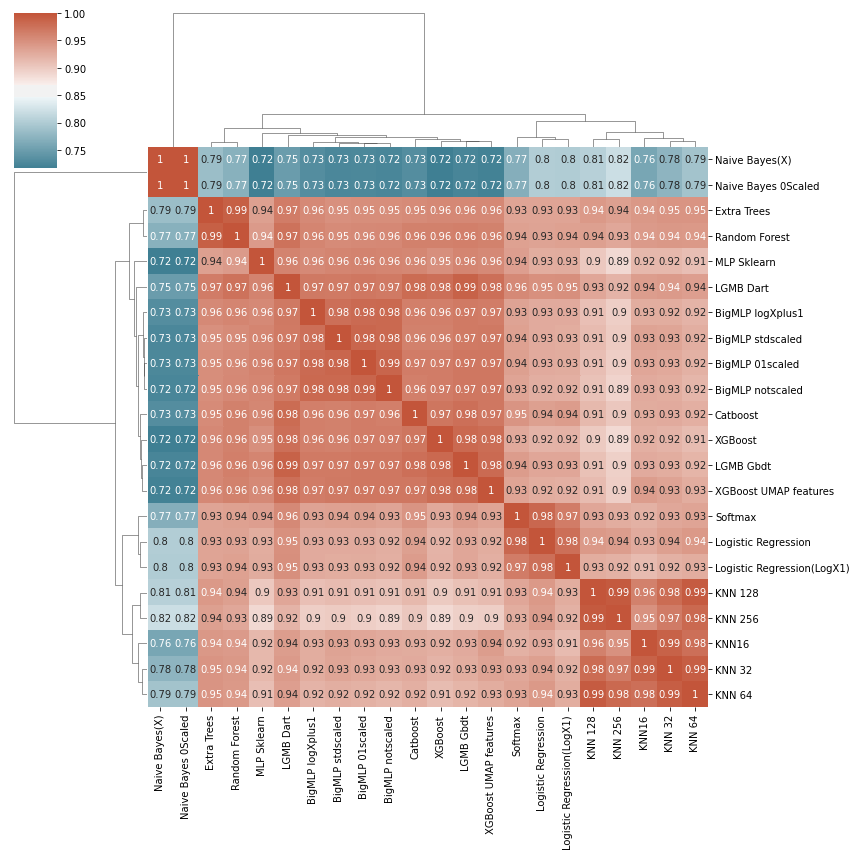

In [0]:
#corrlation map train

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(base_model_df_train.corr(), figsize= (12,12), cmap = cmap, annot=True).ax_row_dendrogram.set_visible(True)

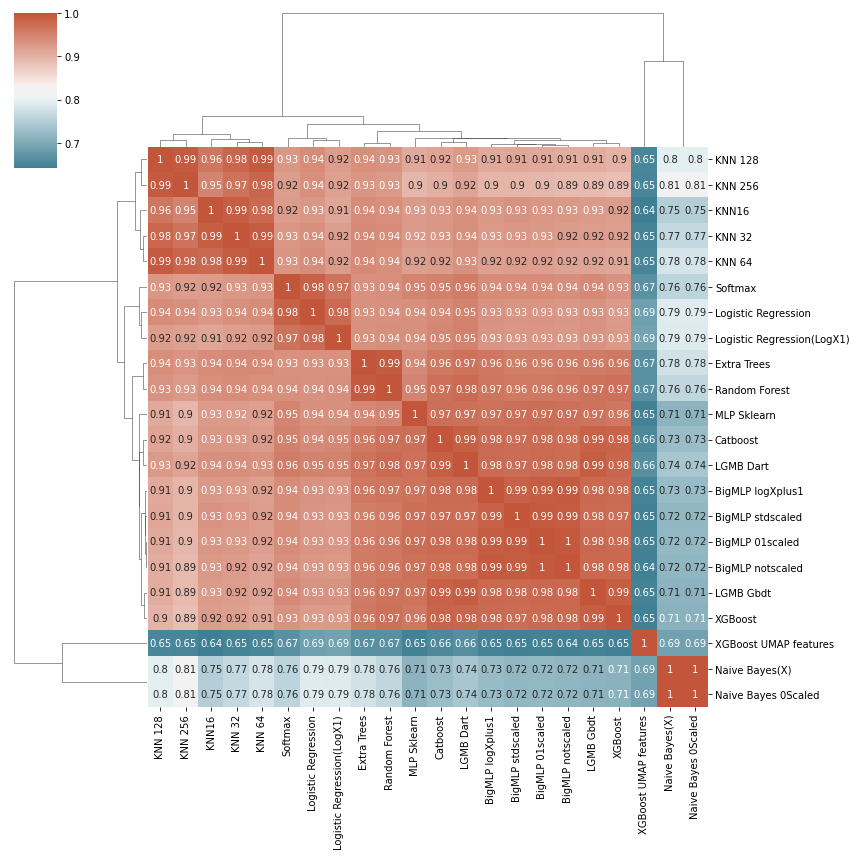

In [0]:
#corrlation map test

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(base_model_df_test.corr(), figsize= (12,12), cmap = cmap, annot=True).ax_row_dendrogram.set_visible(True)

# Concatenate required train and test predictions


In [0]:
#Merging base learner train and test sets

s_train = np.concatenate((BigMLP_01scaled_train, 
                          BigMLP_logXplus1_train, 
                          BigMLP_notscaled_train, 
                          BigMLP_stdscaled_train,
                          catboost_train,
                          extraTrees_train, 
                          KNN16_train,
                          KNN32_train,
                          KNN64_train,
                          KNN128_train,
                          KNN256_train,
                          LGMB_dart_train,
                          LGMB_gbdt_train,
                          smallMLP_scaled_train,
                          NaiveBayes_train,
                          NaiveBayes_scaled_train,
                          randomForest_train,
                          softmax_train,
                          xgboost_train,
                          log_reg_train,
                          log_reg_x1_train
                          ), axis=1)

s_test = np.concatenate((BigMLP_01scaled_test, 
                          BigMLP_logXplus1_test, 
                          BigMLP_notscaled_test, 
                          BigMLP_stdscaled_test,
                          catboost_test,
                          extraTrees_test, 
                          KNN16_test,
                          KNN32_test,
                          KNN64_test,
                          KNN128_test,
                          KNN256_test,
                          LGMB_dart_test,
                          LGMB_gbdt_test,
                          smallMLP_scaled_test,
                          NaiveBayes_test,
                          NaiveBayes_scaled_test,
                          randomForest_test,
                          softmax_test,
                          xgboost_test,
                          log_reg_test,
                          log_reg_x1_test
                          ), axis=1)

# Hyper-tuning meta learners on base model predictions

In [0]:
params_xgboost = {
 "learning_rate"    : [0.095, 0.1, 0.15, 0.2, 0.3],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 'n_estimators'     : [100, 200],
 'tree_method' : ['gpu_hist'] 
}

params_rf = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
    'bootstrap': [False],
    'max_features': ['auto']
}


In [0]:
clf=XGBClassifier()

random_search = RandomizedSearchCV(estimator = clf, 
                      param_distributions = params_xgboost, 
                      n_iter = 10, 
                      cv = 5, 
                      verbose=20, 
                      random_state=2,
                      scoring = 'neg_log_loss', 
                      n_jobs = -1)

random_search.fit(train_log, y_train)

print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

Best: -0.464836 using {'tree_method': 'gpu_hist', 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.3}


In [0]:
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

-0.558392 (0.006666) with: {'tree_method': 'gpu_hist', 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.095, 'gamma': 0.3, 'colsample_bytree': 0.4}
-0.526913 (0.007093) with: {'tree_method': 'gpu_hist', 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.7}
-0.578657 (0.006303) with: {'tree_method': 'gpu_hist', 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
-0.510187 (0.006800) with: {'tree_method': 'gpu_hist', 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.4}
-0.532593 (0.006191) with: {'tree_method': 'gpu_hist', 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.3}
-0.563105 (0.006780) with: {'tree_method': 'gpu_hist', 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 3, 'l

# Training and predicting with meta learners

In [0]:
meta_xgboost = xgb.XGBClassifier(n_estimators= 100,
                        max_depth= 5,
                        min_child_weight = 7,
                        learning_rate = 0.15,
                        gamma= 0.3,
                        colsample_bytree = 0.7,
                        objective = 'multi:softprob',
                        n_threads =-1,
                        tree_method = 'gpu_hist',
                        seed = 1)

meta_calibrated_rf = RandomForestClassifier( 
                                    max_depth = 20,
                                    max_features = 'auto',
                                    min_samples_leaf =4,
                                    min_samples_split = 8,
                                    n_estimators = 200,
                                    n_jobs = -1,
                                    random_state = 1)

#Calibrating random forest
calibrated_RF = CalibratedClassifierCV(meta_calibrated_rf, method='isotonic', cv=5)

# Deep Neural Network meta learner

### Convert labels to numeric

In [0]:
labels = pd.read_csv("/content/gdrive/My Drive/Colab/otto/train.csv")

labels = labels['target']

labels =  labels.map({'Class_1': 1, 
                       'Class_2': 2,              
                       'Class_3': 3, 
                       'Class_4': 4,
                       'Class_5': 5, 
                       'Class_6': 6,
                       'Class_7': 7, 
                       'Class_8': 8,
                       'Class_9': 9})

labels = labels.astype('float64')

### Model shape

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        n_base_models = 22
        self.classifier = nn.Sequential(
            #nn.Dropout(0.3),
            nn.Linear(n_base_models*9, 1000),
            nn.ReLU(),

            #nn.Dropout(0.4),
            nn.Linear(1000,1000),
            nn.ReLU(),

            #nn.Dropout(0.2),
            nn.Linear(1000,9)
        )

    def forward(self,x):
        x = self.classifier(x)
        return x

### Deep NN

In [0]:
def train_NN(x, train_x, train_y, valid_x, valid_y, test_x):

    model = MLP().to('cuda')
    criterion = nn.CrossEntropyLoss().to('cuda')
    # 0.00000185
    # best so far 0.0001
    optimizer = optim.Adam(model.parameters(),weight_decay=0.00007)
    model.train()

    train_losses = []
    valid_losses = []
    epoch_nums = []
    epochs = 250
    best_valid_loss = 50
    log_interval = 10
    start_time = time.time()
    model.train()
    batch_size = 20000

    train_x = train_x.to('cuda')
    train_y = train_y.to('cuda')
    valid_x = valid_x.to('cuda')
    valid_y = valid_y.to('cuda')


    for epoch in range(epochs):

        permutation = torch.randperm(train_x.size()[0])

        for i in range(0,train_x.size()[0], batch_size):
          
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x, batch_y = train_x[indices], train_y[indices]

            outputs = model.forward(batch_x)
            loss = criterion(outputs, batch_y-1)

            loss.backward()
            optimizer.step()

        valid_l = criterion(model.forward(valid_x), valid_y-1).detach()
        train_l = criterion(model.forward(train_x), train_y-1).detach()

        train_losses.append(train_l)
        valid_losses.append(valid_l)
        epoch_nums.append(epoch)

        if valid_l < best_valid_loss:
          torch.save(model, 'best_model.pth')
          best_valid_loss = valid_l

        if epoch % log_interval == 0:
          print('Epoch: {} Train Loss: {:.3f} Validation Loss {:.3f} Best so far: {:.3f}'.format(epoch+1, train_l, valid_l, best_valid_loss))

    print('Time taken: ', time.time()-start_time)

    # Load best model
    best_model = torch.load('best_model.pth')
    best_model.eval()

    # Train set
    outputs = best_model.forward(x)
    probs = F.softmax(outputs, dim=1)
    y_train_pred = probs.cpu().detach().numpy()

    # Test set
    outputs = best_model.forward(test_x)
    probs = F.softmax(outputs, dim=1)
    y_test_pred = probs.cpu().detach().numpy()

    return y_train_pred, y_test_pred, train_losses, valid_losses, epoch_nums

### K Folds meta NN

Running fold  1 of  10
Epoch: 1 Train Loss: 1.390 Validation Loss 1.386 Best so far: 1.386


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.465 Validation Loss 0.462 Best so far: 0.462
Epoch: 21 Train Loss: 0.440 Validation Loss 0.438 Best so far: 0.438
Epoch: 31 Train Loss: 0.427 Validation Loss 0.429 Best so far: 0.429
Epoch: 41 Train Loss: 0.418 Validation Loss 0.423 Best so far: 0.423
Epoch: 51 Train Loss: 0.412 Validation Loss 0.419 Best so far: 0.419
Epoch: 61 Train Loss: 0.407 Validation Loss 0.417 Best so far: 0.416
Epoch: 71 Train Loss: 0.405 Validation Loss 0.417 Best so far: 0.416
Epoch: 81 Train Loss: 0.400 Validation Loss 0.415 Best so far: 0.414
Epoch: 91 Train Loss: 0.398 Validation Loss 0.416 Best so far: 0.414
Epoch: 101 Train Loss: 0.397 Validation Loss 0.415 Best so far: 0.414
Epoch: 111 Train Loss: 0.395 Validation Loss 0.415 Best so far: 0.413
Epoch: 121 Train Loss: 0.390 Validation Loss 0.413 Best so far: 0.413
Epoch: 131 Train Loss: 0.388 Validation Loss 0.415 Best so far: 0.413
Epoch: 141 Train Loss: 0.386 Validation Loss 0.416 Best so far: 0.413
Epoch: 151 Train Loss: 0.385 

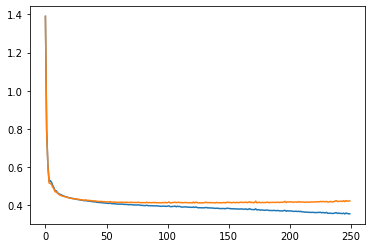

Running fold  2 of  10
Epoch: 1 Train Loss: 1.408 Validation Loss 1.412 Best so far: 1.412


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.469 Validation Loss 0.475 Best so far: 0.475
Epoch: 21 Train Loss: 0.440 Validation Loss 0.452 Best so far: 0.452
Epoch: 31 Train Loss: 0.427 Validation Loss 0.439 Best so far: 0.439
Epoch: 41 Train Loss: 0.418 Validation Loss 0.434 Best so far: 0.434
Epoch: 51 Train Loss: 0.411 Validation Loss 0.430 Best so far: 0.430
Epoch: 61 Train Loss: 0.406 Validation Loss 0.428 Best so far: 0.428
Epoch: 71 Train Loss: 0.402 Validation Loss 0.427 Best so far: 0.427
Epoch: 81 Train Loss: 0.401 Validation Loss 0.429 Best so far: 0.426
Epoch: 91 Train Loss: 0.398 Validation Loss 0.427 Best so far: 0.425
Epoch: 101 Train Loss: 0.394 Validation Loss 0.426 Best so far: 0.425
Epoch: 111 Train Loss: 0.391 Validation Loss 0.427 Best so far: 0.425
Epoch: 121 Train Loss: 0.388 Validation Loss 0.426 Best so far: 0.425
Epoch: 131 Train Loss: 0.386 Validation Loss 0.427 Best so far: 0.425
Epoch: 141 Train Loss: 0.384 Validation Loss 0.429 Best so far: 0.425
Epoch: 151 Train Loss: 0.381 

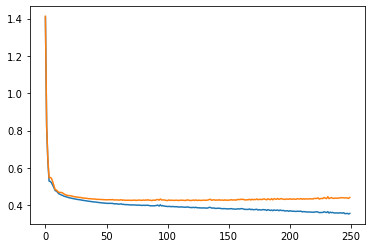

Running fold  3 of  10
Epoch: 1 Train Loss: 1.393 Validation Loss 1.392 Best so far: 1.392


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.469 Validation Loss 0.465 Best so far: 0.465
Epoch: 21 Train Loss: 0.441 Validation Loss 0.438 Best so far: 0.438
Epoch: 31 Train Loss: 0.428 Validation Loss 0.427 Best so far: 0.427
Epoch: 41 Train Loss: 0.419 Validation Loss 0.419 Best so far: 0.419
Epoch: 51 Train Loss: 0.413 Validation Loss 0.414 Best so far: 0.414
Epoch: 61 Train Loss: 0.408 Validation Loss 0.412 Best so far: 0.412
Epoch: 71 Train Loss: 0.405 Validation Loss 0.413 Best so far: 0.411
Epoch: 81 Train Loss: 0.401 Validation Loss 0.411 Best so far: 0.409
Epoch: 91 Train Loss: 0.401 Validation Loss 0.413 Best so far: 0.409
Epoch: 101 Train Loss: 0.398 Validation Loss 0.413 Best so far: 0.409
Epoch: 111 Train Loss: 0.393 Validation Loss 0.409 Best so far: 0.408
Epoch: 121 Train Loss: 0.393 Validation Loss 0.409 Best so far: 0.408
Epoch: 131 Train Loss: 0.388 Validation Loss 0.409 Best so far: 0.408
Epoch: 141 Train Loss: 0.386 Validation Loss 0.408 Best so far: 0.408
Epoch: 151 Train Loss: 0.385 

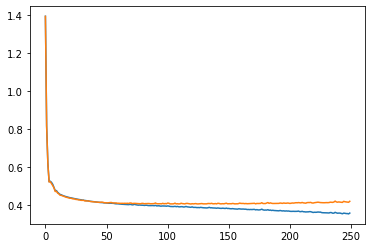

Running fold  4 of  10
Epoch: 1 Train Loss: 1.384 Validation Loss 1.378 Best so far: 1.378


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.467 Validation Loss 0.459 Best so far: 0.459
Epoch: 21 Train Loss: 0.441 Validation Loss 0.437 Best so far: 0.437
Epoch: 31 Train Loss: 0.428 Validation Loss 0.427 Best so far: 0.427
Epoch: 41 Train Loss: 0.419 Validation Loss 0.419 Best so far: 0.419
Epoch: 51 Train Loss: 0.413 Validation Loss 0.416 Best so far: 0.416
Epoch: 61 Train Loss: 0.408 Validation Loss 0.413 Best so far: 0.412
Epoch: 71 Train Loss: 0.406 Validation Loss 0.412 Best so far: 0.411
Epoch: 81 Train Loss: 0.401 Validation Loss 0.411 Best so far: 0.410
Epoch: 91 Train Loss: 0.399 Validation Loss 0.411 Best so far: 0.409
Epoch: 101 Train Loss: 0.397 Validation Loss 0.412 Best so far: 0.408
Epoch: 111 Train Loss: 0.394 Validation Loss 0.413 Best so far: 0.408
Epoch: 121 Train Loss: 0.390 Validation Loss 0.409 Best so far: 0.408
Epoch: 131 Train Loss: 0.389 Validation Loss 0.411 Best so far: 0.408
Epoch: 141 Train Loss: 0.385 Validation Loss 0.410 Best so far: 0.408
Epoch: 151 Train Loss: 0.384 

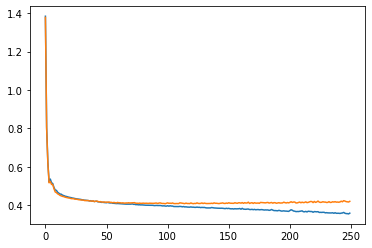

Running fold  5 of  10
Epoch: 1 Train Loss: 1.410 Validation Loss 1.411 Best so far: 1.411


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.466 Validation Loss 0.466 Best so far: 0.466
Epoch: 21 Train Loss: 0.442 Validation Loss 0.441 Best so far: 0.441
Epoch: 31 Train Loss: 0.429 Validation Loss 0.429 Best so far: 0.429
Epoch: 41 Train Loss: 0.421 Validation Loss 0.423 Best so far: 0.422
Epoch: 51 Train Loss: 0.413 Validation Loss 0.417 Best so far: 0.417
Epoch: 61 Train Loss: 0.408 Validation Loss 0.416 Best so far: 0.415
Epoch: 71 Train Loss: 0.408 Validation Loss 0.418 Best so far: 0.413
Epoch: 81 Train Loss: 0.403 Validation Loss 0.415 Best so far: 0.411
Epoch: 91 Train Loss: 0.399 Validation Loss 0.411 Best so far: 0.411
Epoch: 101 Train Loss: 0.399 Validation Loss 0.415 Best so far: 0.410
Epoch: 111 Train Loss: 0.393 Validation Loss 0.410 Best so far: 0.410
Epoch: 121 Train Loss: 0.391 Validation Loss 0.410 Best so far: 0.410
Epoch: 131 Train Loss: 0.388 Validation Loss 0.410 Best so far: 0.409
Epoch: 141 Train Loss: 0.386 Validation Loss 0.410 Best so far: 0.409
Epoch: 151 Train Loss: 0.384 

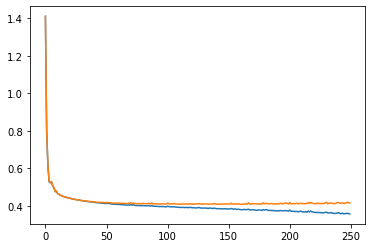

Running fold  6 of  10
Epoch: 1 Train Loss: 1.411 Validation Loss 1.414 Best so far: 1.414


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.465 Validation Loss 0.470 Best so far: 0.470
Epoch: 21 Train Loss: 0.440 Validation Loss 0.447 Best so far: 0.447
Epoch: 31 Train Loss: 0.428 Validation Loss 0.437 Best so far: 0.437
Epoch: 41 Train Loss: 0.419 Validation Loss 0.431 Best so far: 0.431
Epoch: 51 Train Loss: 0.413 Validation Loss 0.427 Best so far: 0.427
Epoch: 61 Train Loss: 0.407 Validation Loss 0.425 Best so far: 0.424
Epoch: 71 Train Loss: 0.404 Validation Loss 0.423 Best so far: 0.423
Epoch: 81 Train Loss: 0.400 Validation Loss 0.422 Best so far: 0.422
Epoch: 91 Train Loss: 0.397 Validation Loss 0.421 Best so far: 0.421
Epoch: 101 Train Loss: 0.395 Validation Loss 0.422 Best so far: 0.420
Epoch: 111 Train Loss: 0.393 Validation Loss 0.423 Best so far: 0.420
Epoch: 121 Train Loss: 0.391 Validation Loss 0.423 Best so far: 0.420
Epoch: 131 Train Loss: 0.387 Validation Loss 0.421 Best so far: 0.420
Epoch: 141 Train Loss: 0.387 Validation Loss 0.422 Best so far: 0.420
Epoch: 151 Train Loss: 0.383 

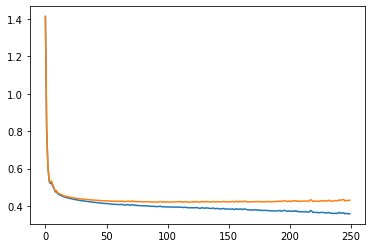

Running fold  7 of  10
Epoch: 1 Train Loss: 1.381 Validation Loss 1.381 Best so far: 1.381


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.467 Validation Loss 0.477 Best so far: 0.477
Epoch: 21 Train Loss: 0.440 Validation Loss 0.448 Best so far: 0.448
Epoch: 31 Train Loss: 0.429 Validation Loss 0.439 Best so far: 0.438
Epoch: 41 Train Loss: 0.419 Validation Loss 0.431 Best so far: 0.431
Epoch: 51 Train Loss: 0.412 Validation Loss 0.426 Best so far: 0.426
Epoch: 61 Train Loss: 0.408 Validation Loss 0.425 Best so far: 0.425
Epoch: 71 Train Loss: 0.404 Validation Loss 0.423 Best so far: 0.423
Epoch: 81 Train Loss: 0.401 Validation Loss 0.422 Best so far: 0.422
Epoch: 91 Train Loss: 0.400 Validation Loss 0.423 Best so far: 0.421
Epoch: 101 Train Loss: 0.394 Validation Loss 0.420 Best so far: 0.420
Epoch: 111 Train Loss: 0.395 Validation Loss 0.422 Best so far: 0.420
Epoch: 121 Train Loss: 0.389 Validation Loss 0.421 Best so far: 0.419
Epoch: 131 Train Loss: 0.386 Validation Loss 0.420 Best so far: 0.419
Epoch: 141 Train Loss: 0.384 Validation Loss 0.420 Best so far: 0.419
Epoch: 151 Train Loss: 0.383 

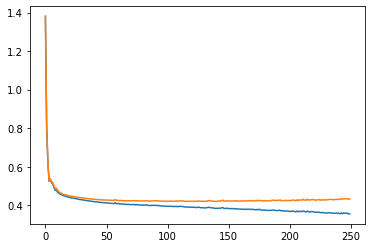

Running fold  8 of  10
Epoch: 1 Train Loss: 1.392 Validation Loss 1.393 Best so far: 1.393


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.464 Validation Loss 0.487 Best so far: 0.487
Epoch: 21 Train Loss: 0.438 Validation Loss 0.461 Best so far: 0.461
Epoch: 31 Train Loss: 0.427 Validation Loss 0.453 Best so far: 0.453
Epoch: 41 Train Loss: 0.418 Validation Loss 0.443 Best so far: 0.443
Epoch: 51 Train Loss: 0.411 Validation Loss 0.440 Best so far: 0.440
Epoch: 61 Train Loss: 0.406 Validation Loss 0.437 Best so far: 0.437
Epoch: 71 Train Loss: 0.404 Validation Loss 0.437 Best so far: 0.436
Epoch: 81 Train Loss: 0.399 Validation Loss 0.434 Best so far: 0.434
Epoch: 91 Train Loss: 0.400 Validation Loss 0.437 Best so far: 0.434
Epoch: 101 Train Loss: 0.394 Validation Loss 0.433 Best so far: 0.433
Epoch: 111 Train Loss: 0.392 Validation Loss 0.435 Best so far: 0.433
Epoch: 121 Train Loss: 0.390 Validation Loss 0.436 Best so far: 0.433
Epoch: 131 Train Loss: 0.387 Validation Loss 0.433 Best so far: 0.433
Epoch: 141 Train Loss: 0.385 Validation Loss 0.434 Best so far: 0.433
Epoch: 151 Train Loss: 0.383 

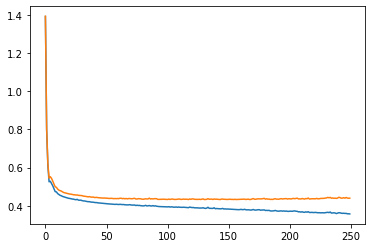

Running fold  9 of  10
Epoch: 1 Train Loss: 1.383 Validation Loss 1.385 Best so far: 1.385


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.466 Validation Loss 0.476 Best so far: 0.476
Epoch: 21 Train Loss: 0.440 Validation Loss 0.448 Best so far: 0.448
Epoch: 31 Train Loss: 0.427 Validation Loss 0.439 Best so far: 0.439
Epoch: 41 Train Loss: 0.419 Validation Loss 0.433 Best so far: 0.432
Epoch: 51 Train Loss: 0.412 Validation Loss 0.429 Best so far: 0.429
Epoch: 61 Train Loss: 0.407 Validation Loss 0.427 Best so far: 0.426
Epoch: 71 Train Loss: 0.403 Validation Loss 0.425 Best so far: 0.425
Epoch: 81 Train Loss: 0.402 Validation Loss 0.426 Best so far: 0.423
Epoch: 91 Train Loss: 0.397 Validation Loss 0.424 Best so far: 0.423
Epoch: 101 Train Loss: 0.394 Validation Loss 0.423 Best so far: 0.423
Epoch: 111 Train Loss: 0.394 Validation Loss 0.426 Best so far: 0.422
Epoch: 121 Train Loss: 0.390 Validation Loss 0.423 Best so far: 0.422
Epoch: 131 Train Loss: 0.389 Validation Loss 0.424 Best so far: 0.422
Epoch: 141 Train Loss: 0.385 Validation Loss 0.423 Best so far: 0.422
Epoch: 151 Train Loss: 0.383 

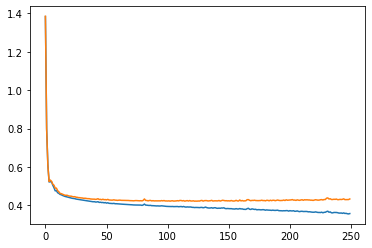

Running fold  10 of  10
Epoch: 1 Train Loss: 1.346 Validation Loss 1.345 Best so far: 1.345


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 Train Loss: 0.468 Validation Loss 0.452 Best so far: 0.452
Epoch: 21 Train Loss: 0.442 Validation Loss 0.430 Best so far: 0.430
Epoch: 31 Train Loss: 0.429 Validation Loss 0.420 Best so far: 0.420
Epoch: 41 Train Loss: 0.420 Validation Loss 0.413 Best so far: 0.413
Epoch: 51 Train Loss: 0.413 Validation Loss 0.410 Best so far: 0.410
Epoch: 61 Train Loss: 0.413 Validation Loss 0.411 Best so far: 0.408
Epoch: 71 Train Loss: 0.405 Validation Loss 0.406 Best so far: 0.406
Epoch: 81 Train Loss: 0.401 Validation Loss 0.405 Best so far: 0.405
Epoch: 91 Train Loss: 0.400 Validation Loss 0.406 Best so far: 0.405
Epoch: 101 Train Loss: 0.396 Validation Loss 0.405 Best so far: 0.404
Epoch: 111 Train Loss: 0.393 Validation Loss 0.404 Best so far: 0.404
Epoch: 121 Train Loss: 0.392 Validation Loss 0.406 Best so far: 0.404
Epoch: 131 Train Loss: 0.388 Validation Loss 0.405 Best so far: 0.404
Epoch: 141 Train Loss: 0.385 Validation Loss 0.405 Best so far: 0.404
Epoch: 151 Train Loss: 0.387 

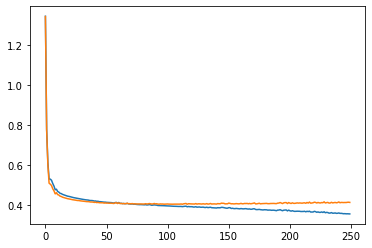

In [0]:
# Deep MLP with K Fold Stacking
train_preds = np.zeros((s_train.shape[0],9))
test_preds_array = []
train_preds_array = []
k=1
test_x = torch.tensor(s_test)
test_x = Variable(test_x).float().to('cuda')

whole_train_x = torch.tensor(s_train)
whole_train_x = Variable(whole_train_x).float().to('cuda')

for train_index, valid_index in kf.split(s_train, labels):


    print('Running fold ', k, 'of ', kf.n_splits)
    k += 1

    train_x, valid_x = s_train[train_index], s_train[valid_index]
    train_y, valid_y = labels.iloc[train_index], labels.iloc[valid_index]

    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y.values)
    valid_x = torch.tensor(valid_x)
    valid_y = torch.tensor(valid_y.values)
    
    train_x = Variable(train_x).float()
    train_y = Variable(train_y).type(torch.LongTensor)
    valid_x = Variable(valid_x).float()
    valid_y = Variable(valid_y).type(torch.LongTensor)
    
    train_preds, test_preds, train_losses, valid_losses, epoch_nums = train_NN(whole_train_x, train_x, train_y, valid_x, valid_y, test_x)

    # For this level, both train and test are the average preds across the whole dataset
    train_preds_array.append(train_preds)
    test_preds_array.append(test_preds)

    plt.figure()
    plt.plot(epoch_nums, train_losses)
    plt.plot(epoch_nums, valid_losses)
    plt.show()

train_preds = np.mean(train_preds_array, axis=0)
test_preds = np.mean(test_preds_array, axis=0)


In [0]:
# Save the results?
# Training

if True:
    # Training
    fname = models_dir + '/train-metaMLP_NEW'
    _ = joblib.dump(train_preds, fname, compress=9)

    # Test
    fname = models_dir + '/test-metaMLP_NEW'
    _ = joblib.dump(test_preds, fname, compress=9)

# Training Meta Learners and predicting on test set

### K-Fold meta learners 


In [0]:
meta_train = np.zeros((s_train.shape[0], n_classes))
meta_test = np.zeros((s_test.shape[0], n_classes))
meta_test_temp = np.zeros((NFOLDS, s_test.shape[0], n_classes))  

k=1

for i, (train_index, test_index) in enumerate(kf.split(s_train, y_train)):
    x_tr = s_train[train_index]
    y_tr = y_train[train_index]
    x_te = s_train[test_index]
    y_te = y_train[test_index]

    print('Running fold ', k, 'of ', kf.n_splits)
    k += 1

    meta_xgboost.fit(x_tr, y_tr)

    meta_train[test_index] = meta_xgboost.predict_proba(x_te)
    meta_test_temp[i, :] = meta_xgboost.predict_proba(s_test)

    print('LogLoss {score}'.format(score=log_loss(y_te, meta_xgboost.predict_proba(x_te))))

meta_test[:] = np.mean(meta_test_temp, axis=0)

  # Training
fname = models_dir + '/train-meta_GBM'
_ = joblib.dump(meta_train, fname, compress=9)

# Test
fname = models_dir + '/test-meta_GBM'
_ = joblib.dump(meta_test, fname, compress=9)

print(meta_train.shape)
print(meta_test.shape)

Running fold  1 of  10
LogLoss 0.40956262278220606
Running fold  2 of  10
LogLoss 0.42375893370587103
Running fold  3 of  10
LogLoss 0.4067080699142466
Running fold  4 of  10
LogLoss 0.408550442396313
Running fold  5 of  10
LogLoss 0.405025499583624
Running fold  6 of  10
LogLoss 0.4159180787112998
Running fold  7 of  10
LogLoss 0.41708971114956633
Running fold  8 of  10
LogLoss 0.42771634720368606
Running fold  9 of  10
LogLoss 0.41704116096305915
Running fold  10 of  10
LogLoss 0.4023572117324999
(61878, 9)
(144368, 9)


In [0]:
NN = joblib.load(models_dir + '/test-metaMLP')
XGB = joblib.load(models_dir + '/test-meta_GBM')
RF = joblib.load(models_dir + '/test-meta_CAL_RF')

#meta_GBM = meta_xgboost.fit(s_train, y_train)
#print("meta_GBM done")

#meta_forest = calibrated_RF.fit(s_train, y_train)
#print("meta_forest done")

#meta_MLP = meta_mlp.fit(s_train, y_train)
#print("done")

#stack_prob_GBM = meta_GBM.predict_proba(s_test)
#_ = joblib.dump(stack_prob_GBM, models_dir + '/train-meta_GBM_preds', compress=9)

#stack_prob_forest = meta_forest.predict_proba(s_test)
#_ = joblib.dump(stack_prob_forest, models_dir + '/train-meta_forest_preds', compress=9)
#stack_prob_MLP = meta_MLP.predict_proba(s_test)

#Averaging meta learner predictions linear
#stack_prob_AVG = (np.array(test_gbm_BAG) +
#                  np.array(test_cal_RF_BAG)+ 
#                  np.array(test_mlp)) / 3.0

a = 1.0 
b = 0.27 
c = 0.802 
d = 0.23

d = 1-a
c = 1-b

stack_prob_AVG = a*np.multiply((NN**b),(XGB**c))+d*RF

# Submit results

In [0]:
#creating submission dataframe 
sub = pd.DataFrame(XGB)
sub.insert(0, 'id', sample['id'])
sub.columns = ['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']

#create submission csv
sub.to_csv("/content/gdrive/My Drive/Colab/otto/sub_test.csv", index=0)